# Compas Analysis

What follows are the calculations performed for ProPublica's analaysis of the COMPAS Recidivism Risk Scores. It might be helpful to open [the methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm/) in another tab to understand the following.

## Loading the Data

We select fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_data = pd.read_csv("compas-scores-two-years.csv")
raw_data.shape[0]

7214

However not all of the rows are useable for the first round of analysis.

There are a number of reasons remove rows because of missing data:
* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [3]:
df = raw_data[["age", "c_charge_degree", "race", "age_cat", "score_text", "sex", "priors_count", 
               "days_b_screening_arrest", "decile_score", "is_recid", "two_year_recid",
               "juv_fel_count", "juv_misd_count", "juv_other_count"]]

In [4]:
df = df[df['days_b_screening_arrest'] <= 30]
df = df[df['days_b_screening_arrest'] >= -30]
df = df[df['is_recid'] != -1]
df = df[df['c_charge_degree'] != 0]
df = df[df['score_text'] != 'N/A']

In [5]:
df['score'] = np.where(df['score_text'] == 'Low', 0, 1)

In [6]:
df.shape[0]

6172

In [7]:
df.head()

,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,juv_fel_count,juv_misd_count,juv_other_count,score
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,0,0,0,0
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,0,0,0,0
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,0,0,1,0
5,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,0,0,0,0,0
6,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,1,0,0,0,1


In [8]:
df = df[['sex','age','age_cat','decile_score','score_text','race','priors_count','juv_fel_count','juv_misd_count','juv_other_count','two_year_recid','score']]

In [9]:
df = df.rename(columns = {'two_year_recid': 'is_recid'})

In [10]:
df.to_csv("recid_audit.csv")

In [11]:
df_small = df[["race", "sex", "is_recid", "score"]]

In [12]:
df_small = df_small.rename(columns={"sex": "gender", "two_year_recid": "label_value"})

In [13]:
df_small.to_csv("recid_aequitas.csv")

# Distributions

### Race

In [14]:
df["race"].value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

Text(0, 0.5, 'Count')

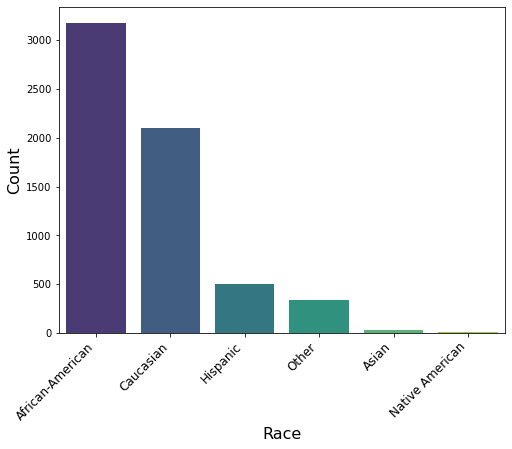

In [15]:
plt.figure(figsize=(8,6))
chart = sns.countplot(df["race"], order=['African-American', 'Caucasian','Hispanic','Other','Asian','Native American'], palette='viridis')

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize='large')
plt.xlabel('Race', fontsize=16)
plt.ylabel('Count', fontsize=16)

### Gender

In [16]:
df["sex"].value_counts()

Male      4997
Female    1175
Name: sex, dtype: int64

Text(0, 0.5, 'Count')

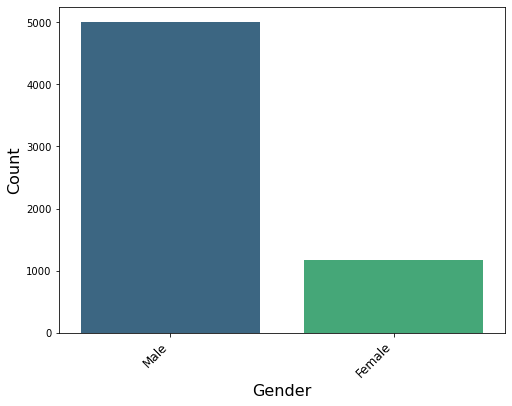

In [17]:
plt.figure(figsize=(8,6))
chart = sns.countplot(df["sex"], order=['Male','Female'], palette='viridis')

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize='large')
plt.xlabel('Gender', fontsize=16)
plt.ylabel('Count', fontsize=16)

### Age group

Text(0, 0.5, 'Count')

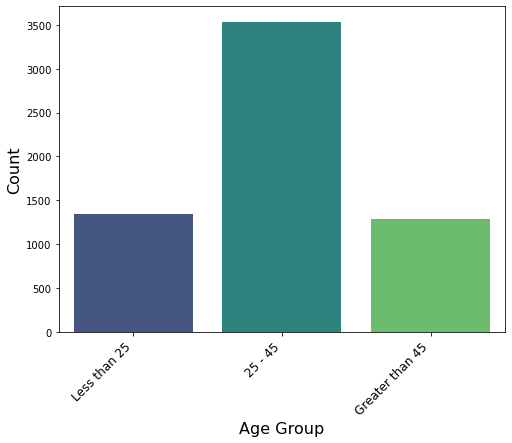

In [18]:
plt.figure(figsize=(8,6))
chart = sns.countplot(df["age_cat"], order=['Less than 25','25 - 45','Greater than 45'], palette='viridis')

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize='large')
plt.xlabel('Age Group', fontsize=16)
plt.ylabel('Count', fontsize=16)

### Two-Year Recidivism

Text(0, 0.5, 'Count')

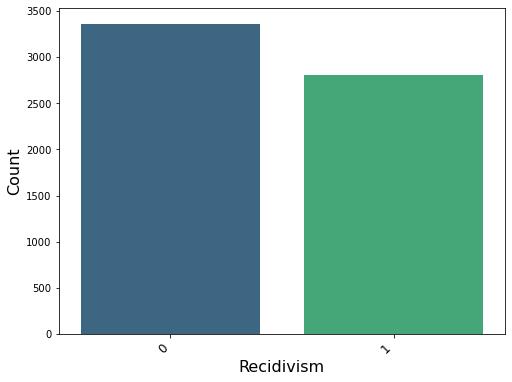

In [19]:
plt.figure(figsize=(8,6))
chart = sns.countplot(df["is_recid"], palette='viridis')

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize='large')
plt.xlabel('Recidivism', fontsize=16)
plt.ylabel('Count', fontsize=16)

### COMPAS decile score

Text(0, 0.5, 'Count')

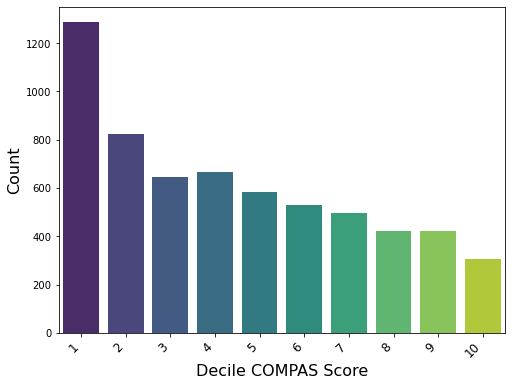

In [20]:
plt.figure(figsize=(8,6))
chart = sns.countplot(df["decile_score"], palette='viridis')

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize='large')
plt.xlabel('Decile COMPAS Score', fontsize=16)
plt.ylabel('Count', fontsize=16)

### COMPAS categorical score

Text(0, 0.5, 'Count')

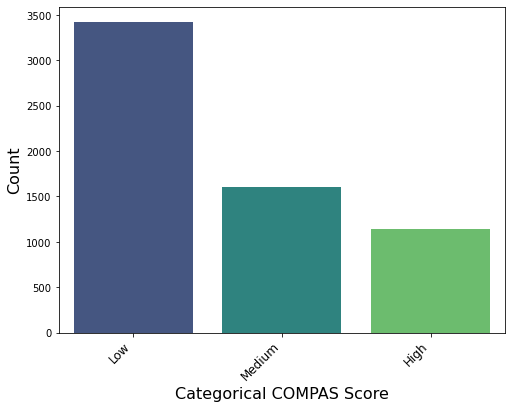

In [21]:
plt.figure(figsize=(8,6))
chart = sns.countplot(df["score_text"], palette='viridis')

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize='large')
plt.xlabel('Categorical COMPAS Score', fontsize=16)
plt.ylabel('Count', fontsize=16)

### COMPAS scores by race

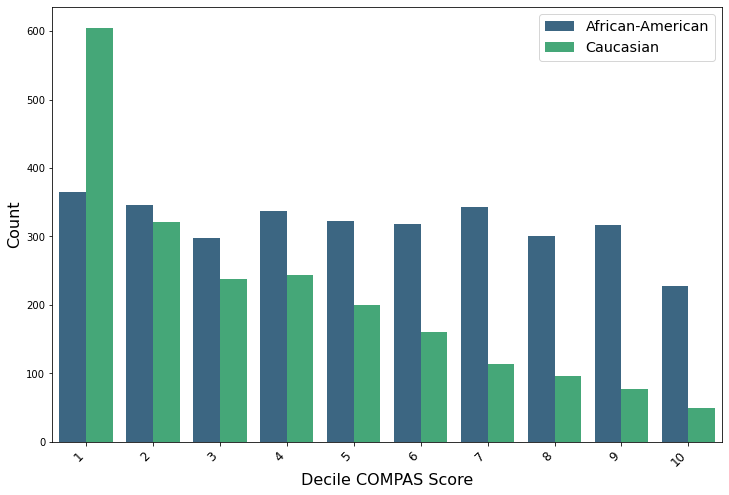

In [22]:
plt.figure(figsize=(12,8))
chart = sns.countplot(df[df["race"].isin(["African-American","Caucasian"])]["decile_score"], palette='viridis', hue=df[df["race"].isin(["African-American","Caucasian"])]["race"])

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize='large')
plt.xlabel('Decile COMPAS Score', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend(fontsize='x-large', title_fontsize='20')

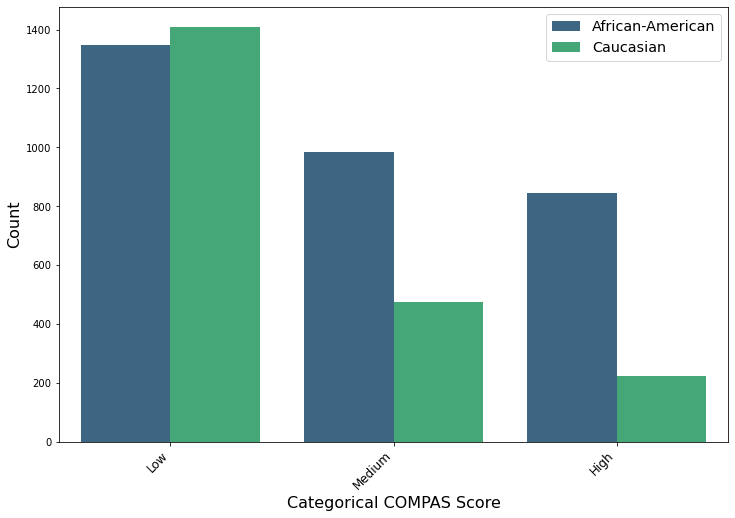

In [23]:
plt.figure(figsize=(12,8))
chart = sns.countplot(df[df["race"].isin(["African-American","Caucasian"])]["score_text"], palette='viridis', hue=df[df["race"].isin(["African-American","Caucasian"])]["race"])

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize='large')
plt.xlabel('Categorical COMPAS Score', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend(fontsize='x-large', title_fontsize='20')

### COMPAS decile score by gender

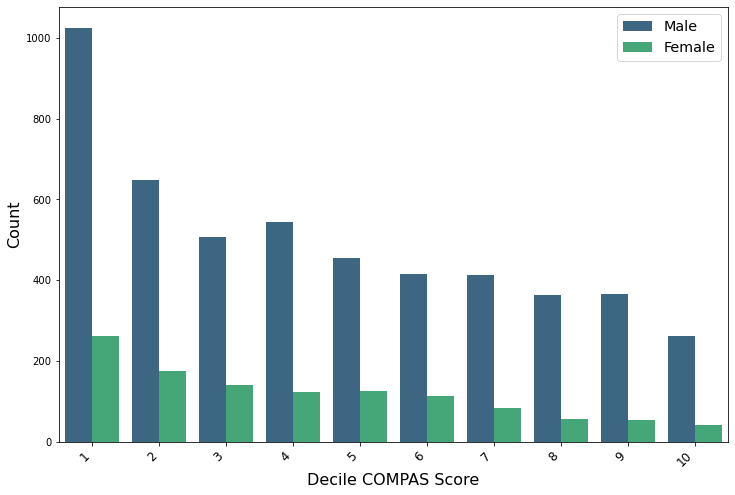

In [24]:
plt.figure(figsize=(12,8))
chart = sns.countplot(df["decile_score"], palette='viridis', hue=df["sex"])

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize='large')
plt.xlabel('Decile COMPAS Score', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend(fontsize='x-large', title_fontsize='20')

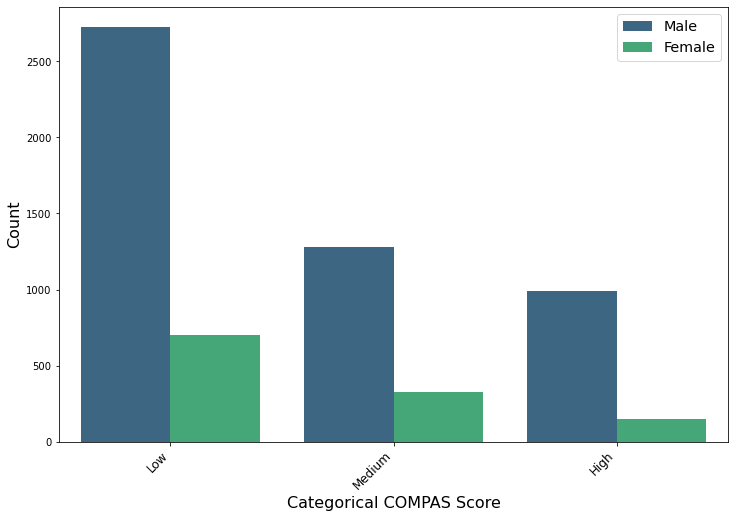

In [25]:
plt.figure(figsize=(12,8))
chart = sns.countplot(df["score_text"], palette='viridis', hue=df["sex"])

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize='large')
plt.xlabel('Categorical COMPAS Score', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend(fontsize='x-large', title_fontsize='20')

### Two-Year Recidivism by Race

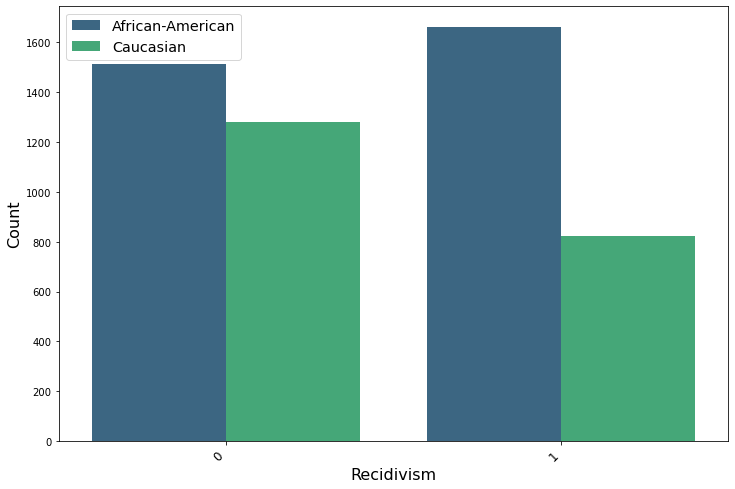

In [26]:
plt.figure(figsize=(12,8))
chart = sns.countplot(df[df["race"].isin(["African-American","Caucasian"])]["is_recid"], palette='viridis', hue=df[df["race"].isin(["African-American","Caucasian"])]["race"])

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize='large')
plt.xlabel('Recidivism', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend(fontsize='x-large', title_fontsize='20')

### Predictions of Recidivism by Race

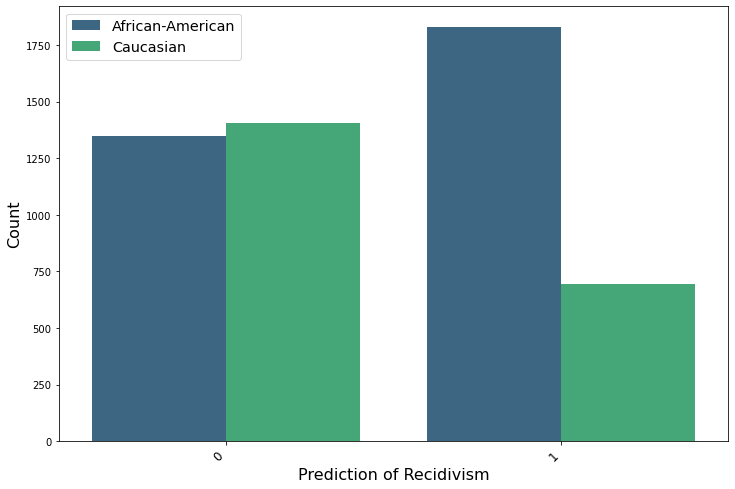

In [27]:
plt.figure(figsize=(12,8))
chart = sns.countplot(df[df["race"].isin(["African-American","Caucasian"])]["score"], palette='viridis', hue=df[df["race"].isin(["African-American","Caucasian"])]["race"])

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize='large')
plt.xlabel('Prediction of Recidivism', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend(fontsize='x-large', title_fontsize='20')

### Two-Year Recidivism by Gender

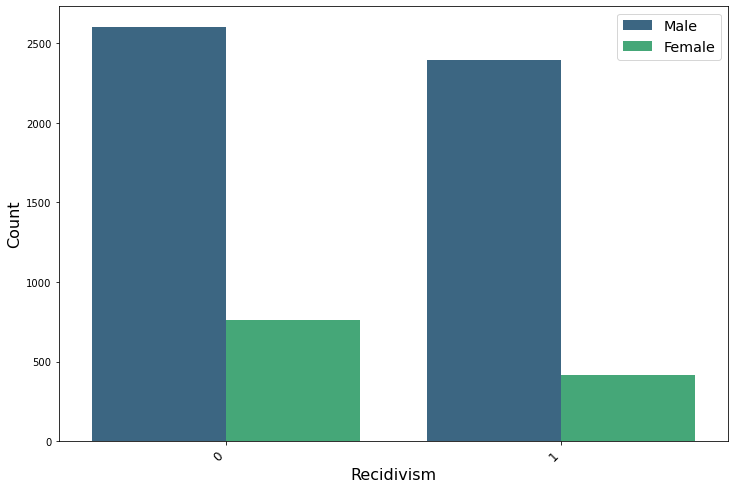

In [28]:
plt.figure(figsize=(12,8))
chart = sns.countplot(df["is_recid"], palette='viridis', hue=df["sex"])

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize='large')
plt.xlabel('Recidivism', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend(fontsize='x-large', title_fontsize='20')

### Predictions of Recidivism by Gender

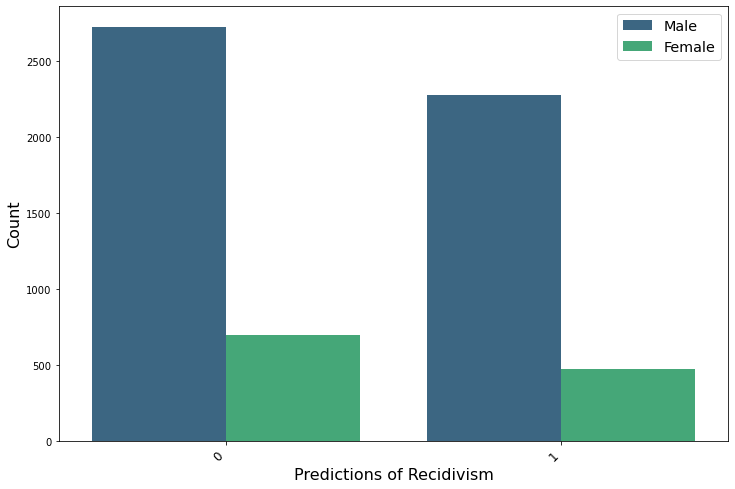

In [29]:
plt.figure(figsize=(12,8))
chart = sns.countplot(df["score"], palette='viridis', hue=df["sex"])

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize='large')
plt.xlabel('Predictions of Recidivism', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend(fontsize='x-large', title_fontsize='20')

# Confusion Matrix

Text(51.0, 0.5, 'True label')

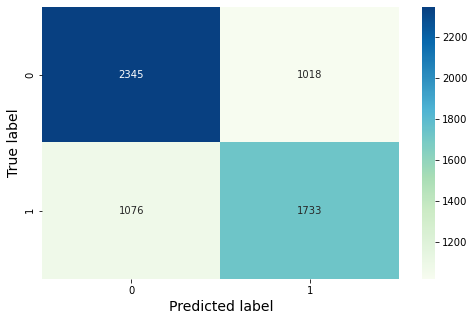

In [30]:
y_true = df.is_recid
y_pred = df.score

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, cmap='GnBu', fmt='g')

plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)

In [31]:
round(accuracy_score(y_true, y_pred), 3)

0.661

## Confusion Matrix by Race

### Confusion Matrix for African-Americans

Text(51.0, 0.5, 'True label')

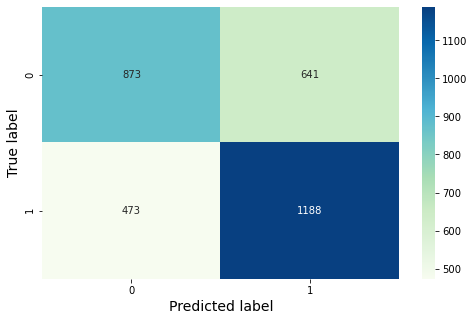

In [32]:
y_true = df[df["race"]=="African-American"].is_recid
y_pred = df[df["race"]=="African-American"].score

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, cmap='GnBu', fmt='g')

plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)

In [33]:
round(accuracy_score(y_true, y_pred), 3)

0.649

### Confusion Matrix for Caucasians

Text(51.0, 0.5, 'True label')

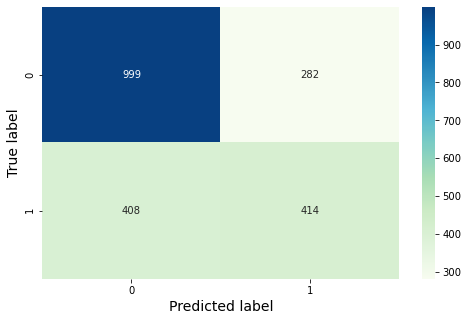

In [34]:
y_true = df[df["race"]=="Caucasian"].is_recid
y_pred = df[df["race"]=="Caucasian"].score

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, cmap='GnBu', fmt='g')

plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)

In [35]:
round(accuracy_score(y_true, y_pred), 3)

0.672

### Confusion Matrix for Hispanics

Text(51.0, 0.5, 'True label')

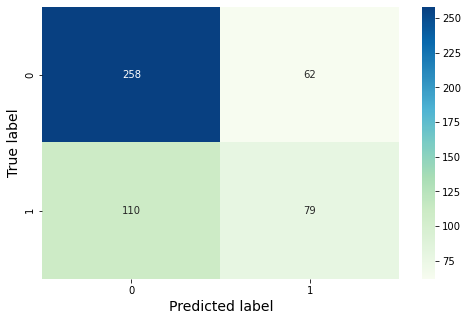

In [36]:
y_true = df[df["race"]=="Hispanic"].is_recid
y_pred = df[df["race"]=="Hispanic"].score

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, cmap='GnBu', fmt='g')

plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)

In [37]:
round(accuracy_score(y_true, y_pred), 3)

0.662

## Confusion Matrix by Gender

### Confusion Matrix for Male

Text(51.0, 0.5, 'True label')

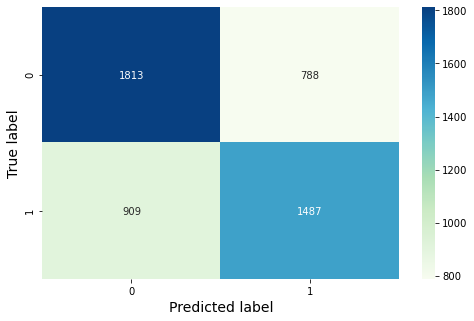

In [38]:
y_true = df[df["sex"]=="Male"].is_recid
y_pred = df[df["sex"]=="Male"].score

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, cmap='GnBu', fmt='g')

plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)

In [39]:
round(accuracy_score(y_true, y_pred), 3)

0.66

### Confusion Matrix for Female

Text(51.0, 0.5, 'True label')

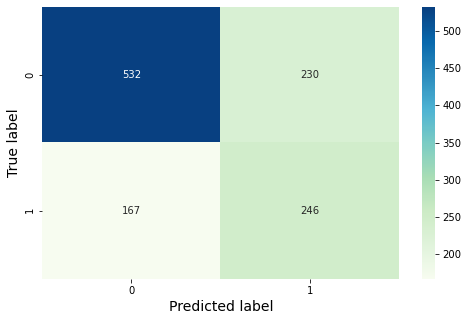

In [40]:
y_true = df[df["sex"]=="Female"].is_recid
y_pred = df[df["sex"]=="Female"].score

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, cmap='GnBu', fmt='g')

plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)

In [41]:
round(accuracy_score(y_true, y_pred), 3)

0.662